In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

# 1. EDA

In [2]:
df = pd.read_csv("src/Walmart_Store_sales.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [3]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))

print("Display of dataset: ")
display(df.head())

print("Basics statistics: ")
df_desc = df.describe(include='all')
display(df_desc)

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 150
Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

    - categorical and numerical features
    - 2 modalities for Holiday_Flag, several for Store
    - Numerical values will need to be standarized = not the same range of values
    - presence of missing values
    - date features to convert

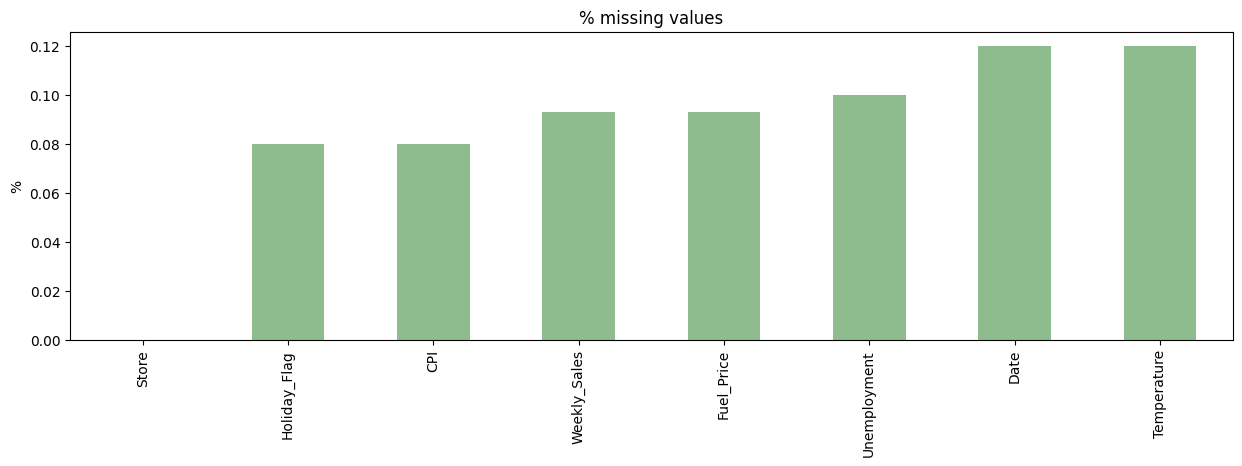

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
# visualisation données manquantes
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), color= "darkseagreen",
    title="% missing values",
    ylabel="%")
plt.show()

In [5]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Visualize pairwise dependencies
fig = px.scatter_matrix(df)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=800, width = 800)
fig.show()

    - not obvious linear relationship between Weekly_sales and other variables, however temperature increasing tends to decrease the amount of sales as the CPI
    - very visible outliers in Unployement feature

# 2. data preparation

In [6]:
# removing missing values
df = df.loc[df["Weekly_Sales"].isna() == False]
display(df.head())
df.shape

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896


(136, 8)

In [7]:
# creation columns year, month, day, day of week
df['DateT']     = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df['year']      = df["DateT"].dt.year
df['month']     = df["DateT"].dt.month
df['day']       = df["DateT"].dt.day
df['dayofweek'] = df["DateT"].dt.dayofweek

display(df.head())

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,DateT,year,month,day,dayofweek
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011-02-18,2011.0,2.0,18.0,4.0
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011-03-25,2011.0,3.0,25.0,4.0
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaT,NaN,NaN,NaN,NaN
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010-05-28,2010.0,5.0,28.0,4.0
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010-05-28,2010.0,5.0,28.0,4.0


In [8]:
print("month: ", df['month'].unique(), "\n")
print("day of week:", df['dayofweek'].unique(), "\n")

month:  [ 2.  3. nan  5.  6. 12.  8. 10.  4.  1.  9. 11.  7.] 

day of week: [ 4. nan] 



In [9]:
## remplacing outlier in numerical features: temperature, fuel_price, unemployment and CPI
to_test = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

for d in to_test:
    to_keep = df[d] < df[d].mean() + 3*df[d].std()
    to_replace = df[d] > df[d].mean() + 3*df[d].std()

    # remplacing by the median value
    df.loc[to_replace, d] = df.loc[to_keep, d].median()
    df.loc[df[d].isna() == True, d] = df.loc[to_keep, d].median()

    print(f"{d} done") 

    #df = df.loc[to_keep,:]
    #print(f"after removing {d} outliers: {df.shape}") 

display(df.head())
print(df.shape)


Temperature done
Fuel_Price done
CPI done
Unemployment done


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,DateT,year,month,day,dayofweek
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011-02-18,2011.0,2.0,18.0,4.0
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011-03-25,2011.0,3.0,25.0,4.0
3,11.0,NaN,1244390.03,0.0,84.57,3.451,214.556497,7.346,NaT,NaN,NaN,NaN,NaN
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010-05-28,2010.0,5.0,28.0,4.0
5,4.0,28-05-2010,1857533.70,0.0,62.25,2.756,126.160226,7.896,2010-05-28,2010.0,5.0,28.0,4.0


(136, 13)


In [10]:
# checking missing values status within the dataset
print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Percentage of missing values: 


Store            0.000000
Date            13.235294
Weekly_Sales     0.000000
Holiday_Flag     8.088235
Temperature      0.000000
Fuel_Price       0.000000
CPI              0.000000
Unemployment     0.000000
DateT           13.235294
year            13.235294
month           13.235294
day             13.235294
dayofweek       13.235294
dtype: float64

    - categorical feature Holiday_Flag still have missing values = if DateT is not empty, it will be replace manually from the Kaggle information, if no info, delete it

In [11]:
# removing missing values
df = df.loc[df["Date"].isna() == False]
df.shape

(118, 13)

In [12]:
df.loc[df["Holiday_Flag"].isna() == True]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,DateT,year,month,day,dayofweek
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011-02-18,2011.0,2.0,18.0,4.0
15,6.0,30-04-2010,1498080.16,NaN,68.91,2.780,211.894272,7.092,2010-04-30,2010.0,4.0,30.0,4.0
43,7.0,26-08-2011,629994.47,NaN,57.60,3.485,194.379637,8.622,2011-08-26,2011.0,8.0,26.0,4.0
48,1.0,05-08-2011,1624383.75,NaN,91.65,3.684,215.544618,7.962,2011-08-05,2011.0,8.0,5.0,4.0
53,14.0,25-03-2011,1879451.23,NaN,41.76,3.625,184.994368,8.549,2011-03-25,2011.0,3.0,25.0,4.0
73,1.0,27-08-2010,1449142.92,NaN,85.22,2.619,211.567306,7.787,2010-08-27,2010.0,8.0,27.0,4.0
90,9.0,09-07-2010,485389.15,NaN,78.51,2.642,214.656430,6.442,2010-07-09,2010.0,7.0,9.0,4.0
118,9.0,18-06-2010,513073.87,NaN,82.99,2.637,215.016648,6.384,2010-06-18,2010.0,6.0,18.0,4.0
136,4.0,08-07-2011,2066541.86,NaN,84.59,3.469,129.112500,5.644,2011-07-08,2011.0,7.0,8.0,4.0


In [13]:
# information from Kaggle
#Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\
#Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\
#Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\
#Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

hf_replace = ['12-02-2010', '11-02-2011', '10-02-2012', '08-02-2013',
              '10-09-2010', '09-09-2011', '07-09-2012', '06-09-2013',
              '26-11-2010', '25-11-2011', '23-11-2012', '29-11-2013',
              '31-12-2010', '30-12-2011', '28-12-2012', '27-12-2013']

df.loc[:,"Holiday_Flag"] = df["Date"].apply(lambda x : 1 if x in hf_replace
                                                else 0)

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,DateT,year,month,day,dayofweek
0,6.0,18-02-2011,1572117.54,0,59.61,3.045,214.777523,6.858,2011-02-18,2011.0,2.0,18.0,4.0
1,13.0,25-03-2011,1807545.43,0,42.38,3.435,128.616064,7.470,2011-03-25,2011.0,3.0,25.0,4.0
4,6.0,28-05-2010,1644470.66,0,78.89,2.759,212.412888,7.092,2010-05-28,2010.0,5.0,28.0,4.0
5,4.0,28-05-2010,1857533.70,0,62.25,2.756,126.160226,7.896,2010-05-28,2010.0,5.0,28.0,4.0
6,15.0,03-06-2011,695396.19,0,69.80,4.069,134.855161,7.658,2011-06-03,2011.0,6.0,3.0,4.0


In [14]:
# checking missing values status within the dataset
print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Percentage of missing values: 


Store           0.0
Date            0.0
Weekly_Sales    0.0
Holiday_Flag    0.0
Temperature     0.0
Fuel_Price      0.0
CPI             0.0
Unemployment    0.0
DateT           0.0
year            0.0
month           0.0
day             0.0
dayofweek       0.0
dtype: float64

In [15]:
import plotly.io as pio
pio.renderers.default = "vscode"
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
fig = px.scatter_matrix(df)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=900, width = 1200)
fig.show()

    - no new trends

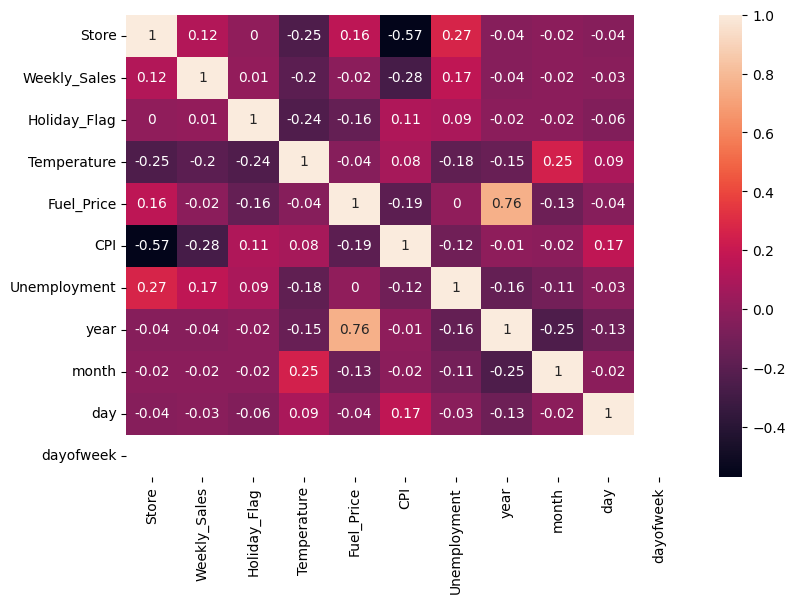

In [17]:
# Correlation matrix
corr_matrix = df.corr().round(2)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr_matrix, annot=True, ax=ax);

    - CPI shows the best (and negative) correlation with Weekly_sales over the several tested features however it is correlated to Store feature, much more than Weekly sales
    - Store displayed also a correlation with temperature and unemployement

# 3. Baseline

## 3.1 Selection of the relevant feature

In [18]:
# spliting data
features_list = ["CPI"]
target_variable = "Weekly_Sales"

X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

print('Y : ')
print(Y.head(2))
print()
print('X :')
print(X.head(2))

Y : 
0    1572117.54
1    1807545.43
Name: Weekly_Sales, dtype: float64

X :
          CPI
0  214.777523
1  128.616064


In [19]:
# dividing Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")

Dividing into train and test sets...
...Done.


## 3.2 preprocessing

In [20]:
# pipeline
print("Preprocessing X_train...")
print(X_train.head(2))
print()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print("...Done!")
print(X_train[0:2,:]) 

print("Preprocessing X_test...")
print(X_test.head(2))
print()
X_test = scaler.transform(X_test)
print("...Done!")
print(X_test[0:2,:])

Preprocessing X_train...
            CPI
139  197.588605
16   196.919506

...Done!
[[0.51781604]
 [0.50064436]]
Preprocessing X_test...
            CPI
110  204.643227
108  132.293936

...Done!
[[ 0.69886504]
 [-1.15789875]]


## 3.3 Linear regression model

In [21]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

# Predictions on training set
Y_train_pred = regressor.predict(X_train)
# Predictions on test set
Y_test_pred = regressor.predict(X_test)

# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

Train model...
...Done.
R2 score on training set :  0.09796275099651464
R2 score on test set :  -0.08899908636425824


In [22]:
from sklearn.model_selection import cross_val_score

print("10-fold cross-validation...")
scores = cross_val_score(regressor, X_train, Y_train, cv=10)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated R2-score is :  -0.0398818269235018
The standard deviation is :  0.19590558198430186


    - negative training score and higher test score = bad model

# 4. Linear regression with all features

## 4.1 preprocessing

In [23]:
# spliting data
features_list = ["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment", "year", "month", "day"]
target_variable = "Weekly_Sales"

X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

# dividing Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")

# Preprocessing
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day']
categorical_features = ['Store', 'Holiday_Flag']

# pipeline
## for numeric
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

## for categorical
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

## column transformer to apply all the transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# preprocessing training set
print(X_train.head(2))
X_train = preprocessor.fit_transform(X_train)
print(X_train[0:2], "\n")

# preprocessing test set
print(X_test.head(2)) 
X_test = preprocessor.transform(X_test)
print(X_test[0:2,:])

Y : 
0    1572117.54
1    1807545.43
4    1644470.66
5    1857533.70
6     695396.19
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0             0        59.61       3.045  214.777523         6.858   
1   13.0             0        42.38       3.435  128.616064         7.470   
4    6.0             0        78.89       2.759  212.412888         7.092   
5    4.0             0        62.25       2.756  126.160226         7.896   
6   15.0             0        69.80       4.069  134.855161         7.658   

     year  month   day  
0  2011.0    2.0  18.0  
1  2011.0    3.0  25.0  
4  2010.0    5.0  28.0  
5  2010.0    5.0  28.0  
6  2011.0    6.0   3.0  
Dividing into train and test sets...
...Done.
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
139    7.0             0        50.60       3.804  197.588605         8.090   
16    13.0             0        76.34       2.850  196.919

## 4.2 Model with regularization and gridsearch

### 4.2.1. Lasso

In [24]:
from sklearn.linear_model import Lasso
# Perform feature selection via lasso for linear model
print("Lasso running...")
lasso1 = Lasso(alpha = 100)
lasso1.fit(X_train, Y_train)
print("...Done.")

print("Lasso (alpha = 100):")
print("R2 score on training set : ", lasso1.score(X_train, Y_train))
print("R2 score on test set : ", lasso1.score(X_test, Y_test))

Lasso running...
...Done.
Lasso (alpha = 100):
R2 score on training set :  0.9797715196850101
R2 score on test set :  0.8998516064850235


In [89]:
from sklearn.model_selection import GridSearchCV
# Perform grid search
print("Grid search...")
regressorL = Lasso()
# Grid of values to be tested
params = {'alpha': [229, 230, 232, 235, 240, 245]}
best_lasso = GridSearchCV(regressorL, param_grid = params, cv = 10)
best_lasso.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_lasso.best_params_)
print("Best R2 score : ", best_lasso.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 240}
Best R2 score :  0.9522487375530861


In [90]:
print("LASSO / R2 score on training set : ", best_lasso.score(X_train, Y_train))
print("LASSO / R2 score on test set : ", best_lasso.score(X_test, Y_test))

LASSO / R2 score on training set :  0.9796910126147651
LASSO / R2 score on test set :  0.9007785104989066


In [79]:
## cross-val score
print("10-fold cross-validation...")
scoresL = cross_val_score(best_lasso, X_train, Y_train, cv=10)
print('The cross-validated R2-score is : ', scoresL.mean())
print('The standard deviation is : ', scoresL.std())

10-fold cross-validation...
The cross-validated R2-score is :  0.9521750338414827
The standard deviation is :  0.021873657063327678


In [80]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_:
    if name == 'num':
        features = features_list
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out()
    column_names.extend(features)

# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = best_lasso.best_estimator_.coef_.transpose(), columns=["coefficients"])
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance[:5]

,coefficients
Store_19.0,1469.898404
year,5894.618917
day,34390.113444
Fuel_Price,35510.172494
Store_6.0,39119.022221


In [81]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'v')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120}
                 )
fig.show(renderer="vscode")

### 4.2.2. Ridge

In [64]:
from sklearn.linear_model import Ridge
# Perform feature selection via ridge for linear model
print("Ridge running...")
ridge1 = Ridge(alpha = 2)
ridge1.fit(X_train, Y_train)
print("...Done.")

print("Ridge (alpha = 2):")
print("R2 score on training set : ", ridge1.score(X_train, Y_train))
print("R2 score on test set : ", ridge1.score(X_test, Y_test))

Ridge running...
...Done.
Ridge (alpha = 2):
R2 score on training set :  0.8880647211941622
R2 score on test set :  0.80204600808415


In [66]:
print("Ridge running...")
ridge1 = Ridge(alpha = 0.05)
ridge1.fit(X_train, Y_train)
print("...Done.")

print("Ridge (alpha = 0.05):")
print("R2 score on training set : ", ridge1.score(X_train, Y_train))
print("R2 score on test set : ", ridge1.score(X_test, Y_test))

Ridge running...
...Done.
Ridge (alpha = 0.05):
R2 score on training set :  0.9793458222616851
R2 score on test set :  0.8988687763189602


In [71]:
# Perform grid search
print("Grid search...")
regressorR = Ridge()
# Grid of values to be tested
params = {'alpha': [0, 0.005, 0.009, 0.01, 0.02]}
best_ridge = GridSearchCV(regressorR, param_grid = params, cv = 10)
best_ridge.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_ridge.best_params_)
print("Best R2 score : ", best_ridge.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0}
Best R2 score :  0.9514652888742916


In [72]:
print("LASSO / R2 score on training set : ", best_ridge.score(X_train, Y_train))
print("LASSO / R2 score on test set : ", best_ridge.score(X_test, Y_test))

LASSO / R2 score on training set :  0.979785492071871
LASSO / R2 score on test set :  0.8988932845241581


In [73]:
## cross-val score
print("10-fold cross-validation...")
scoresR = cross_val_score(best_ridge, X_train, Y_train, cv=10)
print('The cross-validated R2-score is : ', scoresR.mean())
print('The standard deviation is : ', scoresR.std())

10-fold cross-validation...
The cross-validated R2-score is :  0.9509937426988759
The standard deviation is :  0.021734692884611634


# 5. Final model

In [74]:
# spliting data
features_list = ["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment", "year", "month", "day"]
target_variable = "Weekly_Sales"

X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

# Preprocessing
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day']
categorical_features = ['Store', 'Holiday_Flag']

# pipeline
## for numeric
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

## for categorical
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))])

## column transformer to apply all the transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# preprocessing training set
print(X.head(2))
X = preprocessor.fit_transform(X)
print(X[0:2])

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0             0        59.61       3.045  214.777523         6.858   
1   13.0             0        42.38       3.435  128.616064         7.470   

     year  month   day  
0  2011.0    2.0  18.0  
1  2011.0    3.0  25.0  
  (0, 0)	-0.07310729609392373
  (0, 1)	-0.5637501775224394
  (0, 2)	0.9261903426253536
  (0, 3)	-0.5749256949981347
  (0, 4)	0.2199344782623147
  (0, 5)	-1.373014408220967
  (0, 6)	0.19075399256606235
  (0, 11)	1.0
  (1, 0)	-1.0848652974580266
  (1, 1)	0.2773242946808496
  (1, 2)	-1.3157516498894009
  (1, 3)	0.10487510713015341
  (1, 4)	0.2199344782623147
  (1, 5)	-1.056577493826291
  (1, 6)	1.0470735461506686
  (1, 18)	1.0


In [82]:
# training model
model_final = Lasso(alpha=240)
model_final.fit(X, Y)

# predictions
Y_pred = model_final.predict(X)
Y_pred[:2]

array([1550085.87224894, 1879993.12646235])

In [83]:
## cross-val score
print("10-fold cross-validation...")
scores = cross_val_score(model_final, X, Y, cv=10)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated R2-score is :  0.9383255769825896
The standard deviation is :  0.03374156271007487


- Final model is working still producing overfitting but :
    - very small dataset
    - store feature is included another information (like store area, localisation, staff size...) = should be prospected to distangle and identify another relevant features